<a href="https://colab.research.google.com/github/SmartNandini/Music_Genre/blob/main/ANN_OurOwn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ANN

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

import matplotlib.pyplot as plt
import random

import os

import librosa
import math

In [ ]:
DATASET_PATH = "/content/gdrive/MyDrive/Program_Datasets/OurData"
JSON_PATH = "/content/gdrive/MyDrive/Program_Datasets/ourdata.json"
SAMPLE_RATE = 44100
TRACK_DURATION = 60 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

In [ ]:
import audioread
example_file = "/content/gdrive/MyDrive/Program_Datasets/OurData/Disco/Your Sweet Lovin_.mp3"

with audioread.audio_open(example_file) as f:
    framerate = f.samplerate
    duration = f.duration
    nchannels = f.channels
    print("sampling rate = {framerate} Hz, duration = {duration} seconds, channels = {nchannels}".format(**locals()))

sampling rate = 44100 Hz, duration = 60.0 seconds, channels = 2


In [ ]:
example_file = "/content/gdrive/MyDrive/Program_Datasets/OurData/Classical/Spiegel im Spiegel - Version for Violin and Piano.mp3"

with audioread.audio_open(example_file) as f:
    framerate = f.samplerate
    duration = f.duration
    nchannels = f.channels
    print("sampling rate = {framerate} Hz, duration = {duration} seconds, channels = {nchannels}".format(**locals()))

sampling rate = 44100 Hz, duration = 60.0 seconds, channels = 2


In [ ]:
def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    """Extracts MFCCs from music dataset and saves them into a json file along with genre labels.
        """

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

		# load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                # process all segments of audio file
                for d in range(num_segments):

                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract mfcc
                    mfcc = librosa.feature.mfcc(y=signal[start:finish], sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T

                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        print("{}, segment:{}".format(file_path, d+1))

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

In [ ]:
save_mfcc(DATASET_PATH, JSON_PATH , num_segments=10)

Streaming output truncated to the last 5000 lines.
/content/gdrive/MyDrive/Program_Datasets/OurData/Reggae/Botheration.mp3, segment:6
/content/gdrive/MyDrive/Program_Datasets/OurData/Reggae/Botheration.mp3, segment:7
/content/gdrive/MyDrive/Program_Datasets/OurData/Reggae/Botheration.mp3, segment:8
/content/gdrive/MyDrive/Program_Datasets/OurData/Reggae/Botheration.mp3, segment:9
/content/gdrive/MyDrive/Program_Datasets/OurData/Reggae/Private Number.mp3, segment:1
/content/gdrive/MyDrive/Program_Datasets/OurData/Reggae/Private Number.mp3, segment:2
/content/gdrive/MyDrive/Program_Datasets/OurData/Reggae/Private Number.mp3, segment:3
/content/gdrive/MyDrive/Program_Datasets/OurData/Reggae/Private Number.mp3, segment:4
/content/gdrive/MyDrive/Program_Datasets/OurData/Reggae/Private Number.mp3, segment:5
/content/gdrive/MyDrive/Program_Datasets/OurData/Reggae/Private Number.mp3, segment:6
/content/gdrive/MyDrive/Program_Datasets/OurData/Reggae/Private Number.mp3, segment:7
/content/gdrive

**Load Data**

In [ ]:
# path to json
DATA_PATH = "/content/gdrive/MyDrive/Program_Datasets/ourdata.json"

In [ ]:
def load_data(data_path):

    with open(data_path, "r") as f:
        data = json.load(f)

    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data succesfully loaded!")

    return  X, y

In [ ]:
# load data
X, y = load_data(DATA_PATH)

Data succesfully loaded!


In [ ]:
X.shape

(9000, 517, 13)

In [ ]:
# create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

**Simple ANN**

In [ ]:
# build network topology
model = keras.Sequential([

    # input layer
    keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),

    # 1st dense layer
    keras.layers.Dense(512, activation='relu'),

    # 2nd dense layer
    keras.layers.Dense(256, activation='relu'),

    # 3rd dense layer
    keras.layers.Dense(64, activation='relu'),

    # output layer
    keras.layers.Dense(10, activation='softmax')
])

In [ ]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 6721)              0         
                                                                 
 dense (Dense)               (None, 512)               3441664   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 3,590,090
Trainable params: 3,590,090
Non-trainable params: 0
_________________________________________________________________


Model trained with epoch=50

In [ ]:
# train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=50)

Epoch 1/50
197/197 [==============================] - 13s 58ms/step - loss: 12.5985 - accuracy: 0.2417 - val_loss: 5.4818 - val_accuracy: 0.2544
Epoch 2/50
197/197 [==============================] - 10s 52ms/step - loss: 4.0703 - accuracy: 0.3240 - val_loss: 3.7390 - val_accuracy: 0.3156
Epoch 3/50
197/197 [==============================] - 12s 59ms/step - loss: 3.0656 - accuracy: 0.3662 - val_loss: 3.5130 - val_accuracy: 0.3285
Epoch 4/50
197/197 [==============================] - 23s 118ms/step - loss: 2.5332 - accuracy: 0.4106 - val_loss: 3.2334 - val_accuracy: 0.3226
Epoch 5/50
197/197 [==============================] - 14s 71ms/step - loss: 2.2048 - accuracy: 0.4498 - val_loss: 3.3730 - val_accuracy: 0.3444
Epoch 6/50
197/197 [==============================] - 12s 62ms/step - loss: 1.9132 - accuracy: 0.4913 - val_loss: 3.0049 - val_accuracy: 0.3600
Epoch 7/50
197/197 [==============================] - 11s 57ms/step - loss: 1.8351 - accuracy: 0.5016 - val_loss: 3.3856 - val_accurac

In [ ]:
def plot_history(history):

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

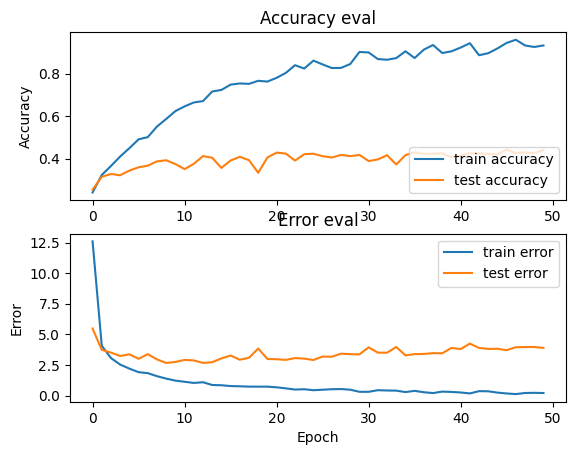

In [ ]:
# plot accuracy and error as a function of the epochs
plot_history(history)

**Managing Overfitting**

In [ ]:
# build network topology
model_regularized = keras.Sequential([

    # input layer
    keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),

    # 1st dense layer
    keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    # 2nd dense layer
    keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    # 3rd dense layer
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    # output layer
    keras.layers.Dense(10, activation='softmax')
])

In [ ]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model_regularized.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# train model
history2 = model_regularized.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=50)

Epoch 1/50
197/197 [==============================] - 15s 72ms/step - loss: 27.9469 - accuracy: 0.1368 - val_loss: 3.6522 - val_accuracy: 0.1741
Epoch 2/50
197/197 [==============================] - 13s 67ms/step - loss: 3.7517 - accuracy: 0.1240 - val_loss: 3.5382 - val_accuracy: 0.1596
Epoch 3/50
197/197 [==============================] - 13s 68ms/step - loss: 3.5838 - accuracy: 0.1214 - val_loss: 3.5433 - val_accuracy: 0.1307
Epoch 4/50
197/197 [==============================] - 13s 65ms/step - loss: 3.5607 - accuracy: 0.1167 - val_loss: 3.5119 - val_accuracy: 0.1367
Epoch 5/50
197/197 [==============================] - 13s 66ms/step - loss: 3.5376 - accuracy: 0.1173 - val_loss: 3.5159 - val_accuracy: 0.1278
Epoch 6/50
197/197 [==============================] - 13s 66ms/step - loss: 3.5189 - accuracy: 0.1094 - val_loss: 3.5144 - val_accuracy: 0.1130
Epoch 7/50
197/197 [==============================] - 12s 63ms/step - loss: 3.5083 - accuracy: 0.0948 - val_loss: 3.4968 - val_accuracy

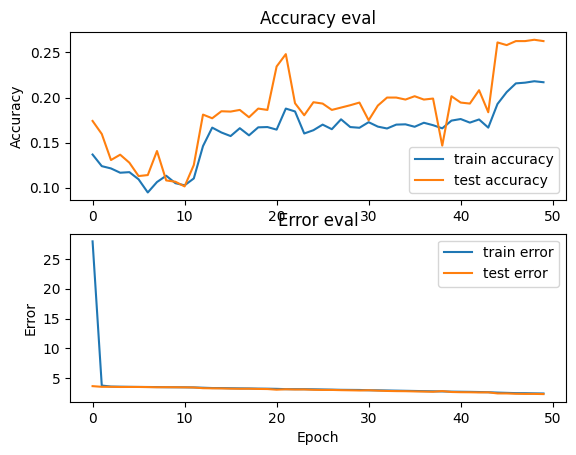

In [ ]:
# plot accuracy and error as a function of the epochs
plot_history(history2)

In [ ]:
# evaluate model on Test Set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

85/85 - 1s - loss: 3.8990 - accuracy: 0.4407 - 770ms/epoch - 9ms/step

Test accuracy: 0.4407407343387604


In [ ]:
# evaluate model on Test Set
test_loss, test_acc = model_regularized.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

85/85 - 2s - loss: 2.3199 - accuracy: 0.2626 - 2s/epoch - 26ms/step

Test accuracy: 0.2625925838947296


In [ ]:
model_regularized.save("ANN_ourdata.h5")

In [ ]:
# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model("ANN_ourdata.h5")

Model trained with epoch=100

In [ ]:
# train model
history3 = model_regularized.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=100)

Epoch 1/100
197/197 [==============================] - 14s 73ms/step - loss: 2.3801 - accuracy: 0.2257 - val_loss: 2.2962 - val_accuracy: 0.2644
Epoch 2/100
197/197 [==============================] - 13s 67ms/step - loss: 2.3810 - accuracy: 0.2157 - val_loss: 2.3079 - val_accuracy: 0.2570
Epoch 3/100
197/197 [==============================] - 14s 73ms/step - loss: 2.3473 - accuracy: 0.2162 - val_loss: 2.2841 - val_accuracy: 0.2515
Epoch 4/100
197/197 [==============================] - 14s 70ms/step - loss: 2.3490 - accuracy: 0.2165 - val_loss: 2.2552 - val_accuracy: 0.2689
Epoch 5/100
197/197 [==============================] - 13s 67ms/step - loss: 2.3255 - accuracy: 0.2229 - val_loss: 2.2396 - val_accuracy: 0.2648
Epoch 6/100
197/197 [==============================] - 13s 66ms/step - loss: 2.3164 - accuracy: 0.2176 - val_loss: 2.2119 - val_accuracy: 0.2637
Epoch 7/100
197/197 [==============================] - 13s 66ms/step - loss: 2.2789 - accuracy: 0.2273 - val_loss: 2.1970 - val_ac

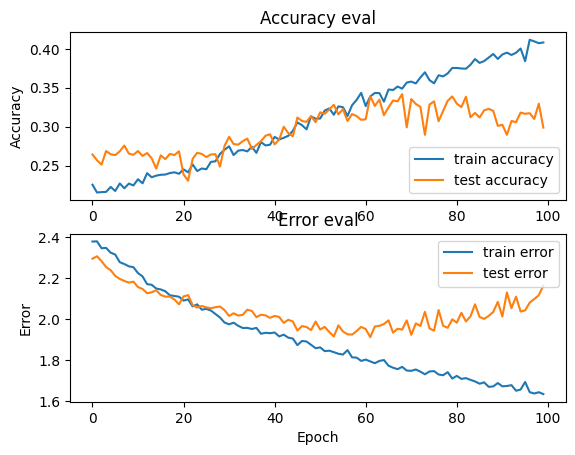

In [ ]:
# plot accuracy and error as a function of the epochs
plot_history(history3)

In [ ]:
# evaluate model on Test Set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

85/85 - 1s - loss: 3.8990 - accuracy: 0.4407 - 728ms/epoch - 9ms/step

Test accuracy: 0.4407407343387604


In [ ]:
# evaluate model on Test Set
test_loss, test_acc = model_regularized.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

85/85 - 1s - loss: 2.1644 - accuracy: 0.2989 - 859ms/epoch - 10ms/step

Test accuracy: 0.2988888919353485


**Prediction on Test Set**

In [ ]:
# pick a sample to predict from the test set
X_to_predict = X_test[50]
y_to_predict = y_test[50]

print("Real Genre:", y_to_predict)

X_to_predict = X_to_predict[np.newaxis, ...]

prediction = model_regularized.predict(X_to_predict)

# get index with max value
predicted_index = np.argmax(prediction, axis=1)

print("Predicted Genre:", int(predicted_index))

Real Genre: 1
1/1 [==============================] - 0s 35ms/step
Predicted Genre: 4


In [ ]:
len(X_test)

2700

In [ ]:
for n in range(10):

  i = random.randint(0,len(X_test))
  # pick a sample to predict from the test set
  X_to_predict = X_test[i]
  y_to_predict = y_test[i]

  print("\nReal Genre:", y_to_predict)

  X_to_predict = X_to_predict[np.newaxis, ...]

  prediction = model_regularized.predict(X_to_predict)

  # get index with max value
  predicted_index = np.argmax(prediction, axis=1)

  print("Predicted Genre:", int(predicted_index))


Real Genre: 6
1/1 [==============================] - 0s 46ms/step
Predicted Genre: 6

Real Genre: 2
1/1 [==============================] - 0s 35ms/step
Predicted Genre: 4

Real Genre: 2
1/1 [==============================] - 0s 36ms/step
Predicted Genre: 6

Real Genre: 0
1/1 [==============================] - 0s 37ms/step
Predicted Genre: 6

Real Genre: 6
1/1 [==============================] - 0s 37ms/step
Predicted Genre: 6

Real Genre: 7
1/1 [==============================] - 0s 39ms/step
Predicted Genre: 6

Real Genre: 6
1/1 [==============================] - 0s 38ms/step
Predicted Genre: 6

Real Genre: 6
1/1 [==============================] - 0s 44ms/step
Predicted Genre: 6

Real Genre: 9
1/1 [==============================] - 0s 40ms/step
Predicted Genre: 6

Real Genre: 6
1/1 [==============================] - 0s 43ms/step
Predicted Genre: 6


**Prediction on New Songs**

In [ ]:
# Audio files pre-processing
def process_input(audio_file, track_duration):

  SAMPLE_RATE = 44100
  NUM_MFCC = 13
  N_FTT=2048
  HOP_LENGTH=512
  TRACK_DURATION = track_duration # measured in seconds
  SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
  NUM_SEGMENTS = 10

  samples_per_segment = int(SAMPLES_PER_TRACK / NUM_SEGMENTS)
  num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / HOP_LENGTH)

  signal, sample_rate = librosa.load(audio_file, sr=SAMPLE_RATE)

  for d in range(10):

    # calculate start and finish sample for current segment
    start = samples_per_segment * d
    finish = start + samples_per_segment

    # extract mfcc
    mfcc = librosa.feature.mfcc(y=signal[start:finish], sr=sample_rate, n_mfcc=NUM_MFCC, n_fft=N_FTT, hop_length=HOP_LENGTH)
    mfcc = mfcc.T

    return mfcc

In [ ]:
genre_dict = {0:"hiphop",1:"country",2:"jazz",3:"classical",4:"metal",5:"pop",6:"rock",7:"blues",8:"reggae",9:"disco"}

In [ ]:
new_input_mfcc = process_input(audio_file="/content/「Nightcore」→ Please Dont Go.mp3", track_duration=60)
type(new_input_mfcc)
new_input_mfcc.shape

(517, 13)